In [74]:
# install and import libraries
%%capture
!pip install ir_datasets
!pip install demoji

import numpy as np
import pandas as pd
import ir_datasets
import demoji


import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from collections import Counter

pd.set_option('max_colwidth', 800)

In [75]:
# load dataset
dataset = ir_datasets.load("cord19/trec-covid")
print(f"queries: {dataset.queries_count()}, docs: {dataset.docs_count()}, qrels: {dataset.qrels_count()}")

queries: 50, docs: 192509, qrels: 69318


# Part 1: Analysis of Queries and Documents

In [76]:
%%capture
# convert the collection in a dataframe
queries = pd.DataFrame(dataset.queries_iter())
docs = pd.DataFrame(dataset.docs_iter())
qrels = pd.DataFrame(dataset.qrels_iter())

docs['date'] = pd.to_datetime(docs['date'])

In [ ]:
display(queries.sample(5))
display(docs.sample(5))
display(qrels.sample(5))

* numbers
* punctuation
* symbols
* whitespaces
* stop words
* HTML tags
* repeated characters
* URLs
* emojis

---

- stemming / lemmatization ?

## Preprocessing

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  


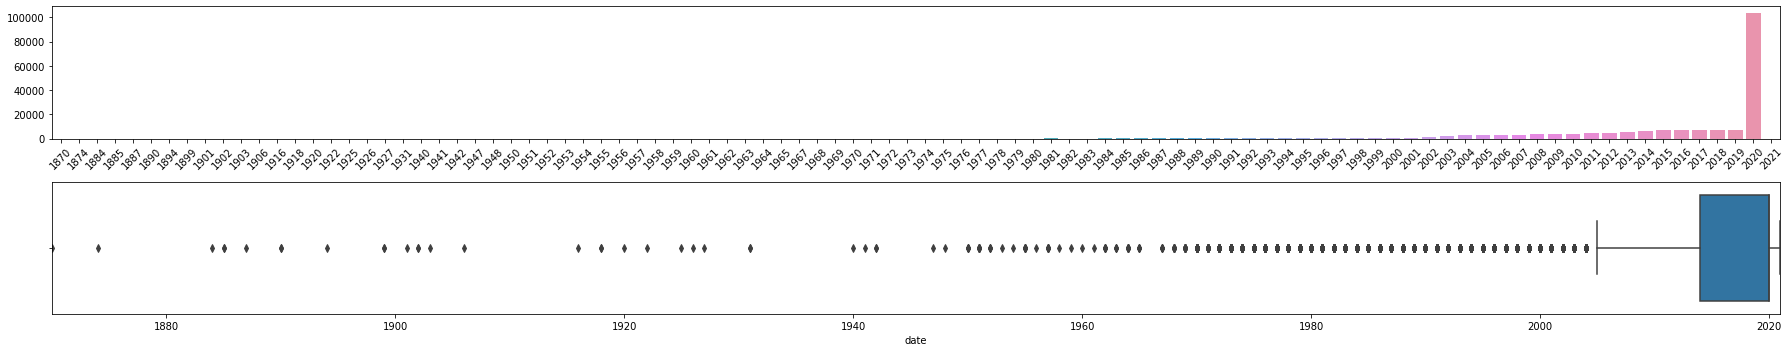

In [77]:
years = docs["date"].dt.year
years.dropna(inplace=True)
years = years.astype(int)

u_years, u_counts = np.unique(years, return_counts=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 5))

sns.barplot(x=u_years, y=u_counts, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)

sns.boxplot(x=years, ax=ax2, orient="h")
ax2.margins(0)

fig.tight_layout()

In [78]:
import re
import datetime as dt

keywords = ["covid 19", "covid-19", "covid19", "sars-cov-2", "sarscov2", 
            "sars cov 2", "2019-nCoV", "Wuhan virus", "Chinese flu",
            "COronaVIrusDisease"]

keep = set()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
  text = " ".join([row["title"], row["abstract"]])
  if any(re.findall(r'|'.join(keywords), text, re.IGNORECASE)):
    keep.add(index)

  # the few documents without date contain at least one keyword
  if row["date"] and row["date"] is not pd.NaT:
    if row["date"].year >= 2019:         
        if any(re.findall(r'coronavirus', " ".join([row["title"], row["abstract"]]), re.IGNORECASE)):
          keep.add(index)

print(f"{len(keep)}, {round(len(keep) / len(docs) * 100)}%")

docs = docs.iloc[list(keep)]

  0%|          | 0/192509 [00:00<?, ?it/s]

84048, 44%


In [79]:
import re
import html
import string

from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet as wn

def remove_urls(text):
    return re.sub(r'https?://\S+|www.\.\S+', '', text)

# decidere se tenere qualche carattere
def remove_punctuation(text):
    return "".join([i for i in text if i not in string.punctuation])

def remove_extra_whitespace(text):
    return " ".join(text.split())

def replace_html_entities(text):
    return html.unescape(text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

# TODO
def replace_emojis(text):
    pass
def remove_numbers(text):
    pass


# il lemmatizer di wordnet ha solo questi 4 tag 
def pos2wordnet(nltk_pos):
  if nltk_pos.startswith('J'):
    return wn.ADJ
  elif nltk_pos.startswith('V'):
    return wn.VERB
  elif nltk_pos.startswith('N'):
    return wn.NOUN
  elif nltk_pos.startswith('R'):
    return wn.ADV
  else:
    return wn.NOUN


def preprocess(text):
  sentences = nltk.sent_tokenize(text)
  
  tokens_list = []
  for sent in sentences:
    sent = sent.lower()
    sent = remove_extra_whitespace(sent)
    sent = remove_urls(sent)
    sent = replace_html_entities(sent) # before removing punctuation (&\w+;)
    sent = remove_punctuation(sent)
    sent = remove_stopwords(sent)

    tokens = nltk.word_tokenize(sent)
    tokens_list.append(tokens)

  tagged_tokens = nltk.pos_tag_sents(tokens_list)

  wnl = WordNetLemmatizer()

  result = []
  for tokens in tagged_tokens:
    for (token, pos) in tokens:
      t = wnl.lemmatize(token, pos2wordnet(pos))
      result.append(t)
    
  return result

In [95]:
text = docs["title"][4582]
x = preprocess(text)
text, x

('Therapeutic strategies in an outbreak scenario to treat the novel coronavirus originating in Wuhan, China',
 ['therapeutic',
  'strategy',
  'outbreak',
  'scenario',
  'treat',
  'novel',
  'coronavirus',
  'originate',
  'wuhan',
  'china'])

## Word Cloud

In [44]:
titles = []
abstracts = []

for index, row in tqdm(docs.iterrows(), total=len(docs)):
  title_tokens = preprocess(row["title"])
  abstract_tokens = preprocess(row["abstract"])

  titles.extend(title_tokens)
  abstracts.extend(abstract_tokens)

  0%|          | 0/84048 [00:00<?, ?it/s]

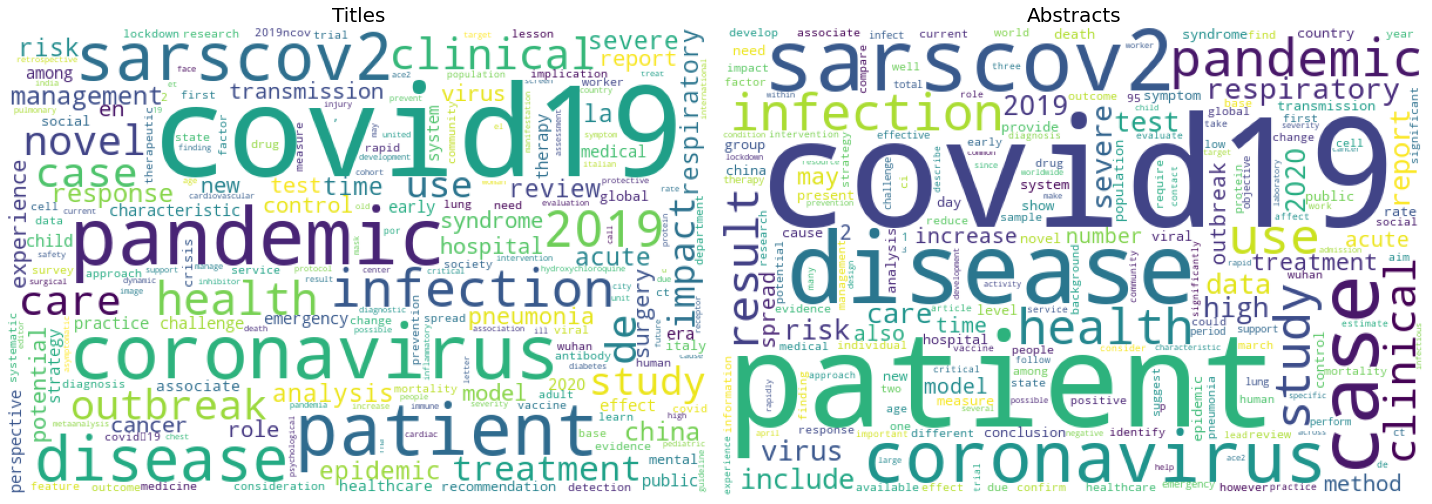

In [72]:
counter_title = Counter(titles)
counter_abstract = Counter(abstracts)

wc1 = WordCloud(collocations=False, background_color="white", width=600, height=400)
wc2 = WordCloud(collocations=False, background_color="white", width=600, height=400)

wc_titles = wc1.fit_words(counter_title)
wc_abstracts = wc2.fit_words(counter_abstract)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.imshow(wc_titles)
ax1.set_title("Titles", fontsize=20)
ax1.axis("off")

ax2.imshow(wc_abstracts)
ax2.set_title("Abstracts", fontsize=20)
ax2.axis("off")

fig.tight_layout()

## Token Statistics

In [70]:
print("\n[Number of Tokens]")
print("Titles:", len(counter_title.keys()))
print("Abstracts:", len(counter_abstract.keys()))

k = 10
top_k_titles = [word for word, count in counter_title.most_common(k)]
top_k_abstracts = [word for word, count in counter_abstract.most_common(k)]

print(f"\n[Top {k} Most Common Tokens]")
print(f"Titles: {', '.join(top_k_titles)}")
print(f"Abstracts: {', '.join(top_k_abstracts)}")


[Number of Tokens]
Titles: 29966
Abstracts: 116791

[Top 10 Most Common Tokens]
Titles: covid19, pandemic, coronavirus, patient, sarscov2, disease, infection, 2019, health, clinical
Abstracts: covid19, patient, disease, sarscov2, case, coronavirus, pandemic, infection, use, study


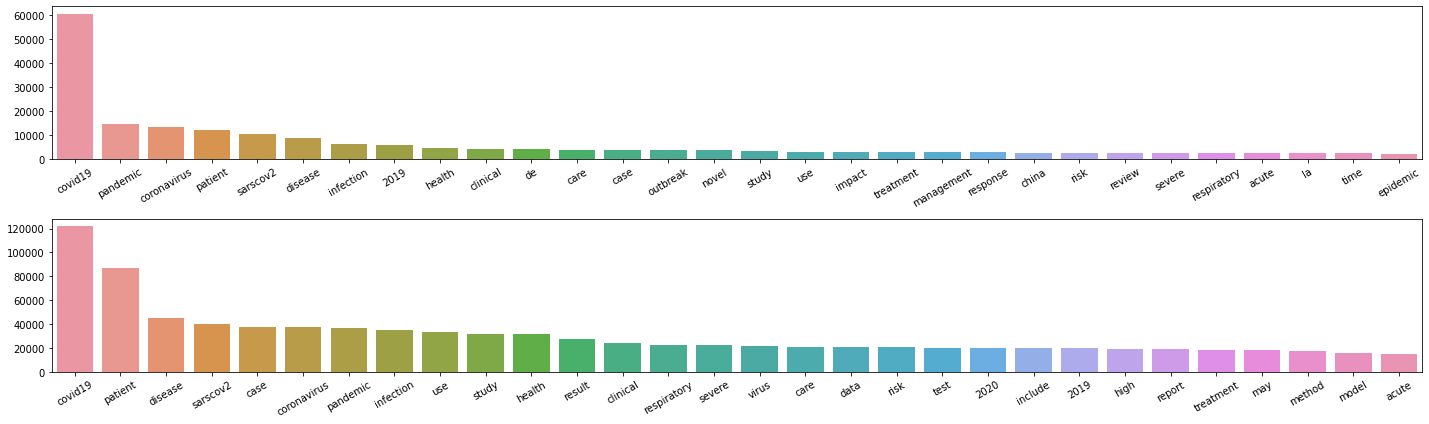

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 30

common_titles = dict(counter_title.most_common(k))
x_title = list(common_titles.keys())
y_title = list(common_titles.values())

common_abstracts = dict(counter_abstract.most_common(k))
x_abstract = list(common_abstracts.keys())
y_abstract = list(common_abstracts.values())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
sns.barplot(x=x_title, y=y_title, ax=ax1)
sns.barplot(x=x_abstract, y=y_abstract, ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 30)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 30)
fig.tight_layout()

## Entities

# Part 2: Basic Search

# Part 3: Advanced Search (Optional)

# NOTE

prof: importate la precision. l'obiettivo é riportare la risposta migliore
